Code to prepare and plot the altimetry input data files, both for Diva2D and DivaND.

In [1]:
import os
import re
import glob
import datetime
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
from matplotlib import rcParams
import netCDF4
import logging

## Configuration

Logging

In [2]:
logger = logging.getLogger()
logger.setLevel(logging.INFO)

Plotting (should be ideally in `matplotlibrc` but seems not to work with virtualenv).

In [3]:
rcParams.update({'font.size': 16, 'figure.dpi': 300, 'savefig.bbox': 'tight'})
# rcParams.keys

# Input parameters

## Files and directories

In [4]:
databasedir = "/home/ctroupin/Data/AVISO/regional-mediterranean/delayed-time/along-track/filtered/adt"
outputdir = "../data/"
figdir = "../figures/"
missionlist = ["al", "c2", "h2", "j2"]

## Domain and period of interest

In [5]:
coordinates = [-6.75, 40.001, 30, 48.]
year, month, day, interval = 2014, 5, 25, 10
timescale = 5.        # temporal scale in days, used to compute weights for Diva

## Map projection

In [6]:
m = Basemap(projection='merc',
            llcrnrlon=coordinates[0], llcrnrlat=coordinates[2],
            urcrnrlon=coordinates[1], urcrnrlat=coordinates[3],
            lat_ts=0.5 * (coordinates[2] + coordinates[3]), resolution='i')

## Track class

In [29]:
class Track(object):
    """
    Object that represent an altimeter track: positions, time and ADT
    """
    def __init__(self, filename):
        """
        Read the values from the selected file name
        """
        self.filename = filename
        
        if os.path.exists(self.filename):
            with netCDF4.Dataset(self.filename, 'r') as nc:
                self.lon = nc.variables['longitude'][:]
                self.lat = nc.variables['latitude'][:]
                self.time = nc.variables['time'][:]
                self.adt = nc.variables['ADT'][:]
                self.npoints = len(self.lon)
            # Change longitude so that they lie between -180 and 180
            self.lon[self.lon > 180.] -= 360.
            
        else:
            logging.warning("File {0} doesn't exist".format(self.filename))
            self.lon=[]
            self.lat=[]
            self.time=[]
            self.adt=[]
            self.npoints=0
            
    def computeTimeWeights(self, timescale, timemid):
        """
        Compute the data weights (4th column in Diva2D data files) 
        using the time difference between the actual measurement and 
        the mean time of the considered period
        Parameters:
        -----------
        timescale: float indicating the temporal scale (in days ; has to be 
        consistent with the units of the time in the AVISO files).
        timemid: float indicating the reference time (in days since 
        January 1st, 1950 to ensure consistency with AVISO files).
        """

        self.timeweight = np.exp( - abs(self.time - timemid) / timescale)
            
    def addToPlot(self, **kwargs):
        """
        Add the data points as a scatter plot
        """
        plt.scatter(self.lon, self.lat, c=self.adt, **kwargs)
        
    def addToMap(self, m, **kwargs):
        """
        Add the data points as a scatter plot to an existing map
        """
        m.scatter(self.lon, self.lat, c=self.adt, latlon=True, **kwargs)
        
    def writoToTextfile(self, filename):
        if not os.path.exists(filename):
            logging.info("Creating new file {0}".format(filename))
            
        with open(filename, 'a') as f:
            for lon, lat, time, adt in zip(self.lon, self.lat, self.time, self.adt):
                f.write(' '.join((str(lon), str(lat), str(time), str(adt), '\n')))
                
    def writeToDivaFile(self, filename, timescale, timemid):
        """
        Write a Diva2D file: lon | lat | field | weight
        where the weights are computed using the time difference between the actual measurement and 
        the mean time of the considered period
        """
        #computeTimeWeights(self, timescale, timemid)
        self.timeweight = np.exp( - abs(self.time - timemid) / timescale)
        
        if not os.path.exists(filename):
            logging.info("Creating new file {0}".format(filename))
            
        with open(filename, 'a') as f:
            for lon, lat, adt, weight in zip(self.lon, self.lat, self.adt, self.timeweight):
                f.write(' '.join((str(lon), str(lat), str(adt), str(weight), '\n')))

## Generate strings from the selected periods

In [30]:
def prepareDateStrings(year, month, day, interval):
    """
    Create a string that will be used as a suffix in the file name
    And another one used on the figure title
    """
    datemid = datetime.datetime(year, month, day)
    datestart = datemid - datetime.timedelta(interval)
    dateend = datemid + datetime.timedelta(interval)
    logging.debug("Start date: {0}".format(datestart))
    logging.debug("End   date: {0}".format(dateend))
    
    # Create string that will be used for filename
    fignamesuffix = datestart.strftime("%Y%m%d") + '_' + dateend.strftime("%Y%m%d")
    figtitledate = datestart.strftime("%Y-%m-%d") + '$-$' + dateend.strftime("%Y-%m-%d")
    return fignamesuffix, figtitledate

## Generate list of files for the selected period

Based on the filenames, we can easily identify the files corresponding to the time of interest:
* datemid is the central time of the considered period
* datestart is the start date
* dateend is the last day.

In [31]:
def makeFileList(databasedir, missionlist, year, month, day, interval):
    """
    Create a list of files from the selected directory and missions 
    with dates that are inside the interval determined by year, month, day and interval
    Parameters:
    -----------
    databasedir: main directory containing the data files
    missionlist: list or tuple of strings for the sub-directories, one per mission
    year, month, day: integers that sets the central day of the period of interest
    interval: integer indicating the number of days before and after the central day of the period
    """
    datemid = datetime.datetime(year, month, day)
    datestart = datemid - datetime.timedelta(interval)
    dateend = datemid + datetime.timedelta(interval)
    logging.debug("Start date: {0}".format(datestart))
    logging.debug("End   date: {0}".format(dateend))
    
    # Create list of days in format YYYYMMDD
    datelist = []
    nfiles = 0
    dd = datestart
    while dd != dateend:
        datelist.append(dd.strftime("%Y%m%d"))
        dd += datetime.timedelta(1)

    # Create the file list
    filelist = []
    for mission in missionlist:
        logging.info("Working on file from mission {0}".format(mission))
        datadir = os.path.join(databasedir, mission)
        for dates in datelist:
            logging.debug(dates)
            fname = "dt_med_{0}_adt_vfec_{1}_{2}.nc".format(mission, dates, '*')
            flist = glob.glob(os.path.join(datadir, "".join((dates[:4], '/', fname))))
            
            # Check if at least one file is found
            # with H2 mission some files are missing
            if len(flist) != 0:
                filelist.append(flist[0])
                nfiles += 1
    logging.info("Found {0} files for the selected period and missions".format(nfiles))
    return filelist

# Main loop

Compute central time

In [32]:
datemid = datetime.datetime(year, month, day).toordinal() - datetime.datetime(1950, 1, 1).toordinal()
logging.info("Central time (in days since January 1st, 1500): {0}".format(datemid))

INFO:root:Central time (in days since January 1st, 1500): 23520


Create the list of files.

In [33]:
filelist = makeFileList(databasedir, missionlist, year, month, day, interval)

INFO:root:Working on file from mission al
INFO:root:Working on file from mission c2
INFO:root:Working on file from mission h2
INFO:root:Working on file from mission j2
INFO:root:Found 77 files for the selected period and missions


In [34]:
fignamesuffix, figtitledate = prepareDateStrings(year, month, day, interval)
logging.info(fignamesuffix)

INFO:root:20140515_20140604


## File and figure names

In [35]:
outputfilename = "ADT_{0}.dat".format(fignamesuffix)
divafilename =  "data_{0}.dat".format(fignamesuffix)
figname = "ADT_{0}".format(fignamesuffix)
logging.info("Text file name: {0}".format(outputfilename))
logging.info("Figure name: {0}".format(figname))

INFO:root:Text file name: ADT_20140515_20140604.dat
INFO:root:Figure name: ADT_20140515_20140604


## Make the plot and write data to text files

/home/ctroupin/Software/PythonEnvs/Diva-python3.6/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3222: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/home/ctroupin/Software/PythonEnvs/Diva-python3.6/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3231: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.hold(b)
INFO:root:Creating new file ../data/ADT_20140515_20140604.dat
INFO:root:Creating new file ../data/data_20140515_20140604.dat


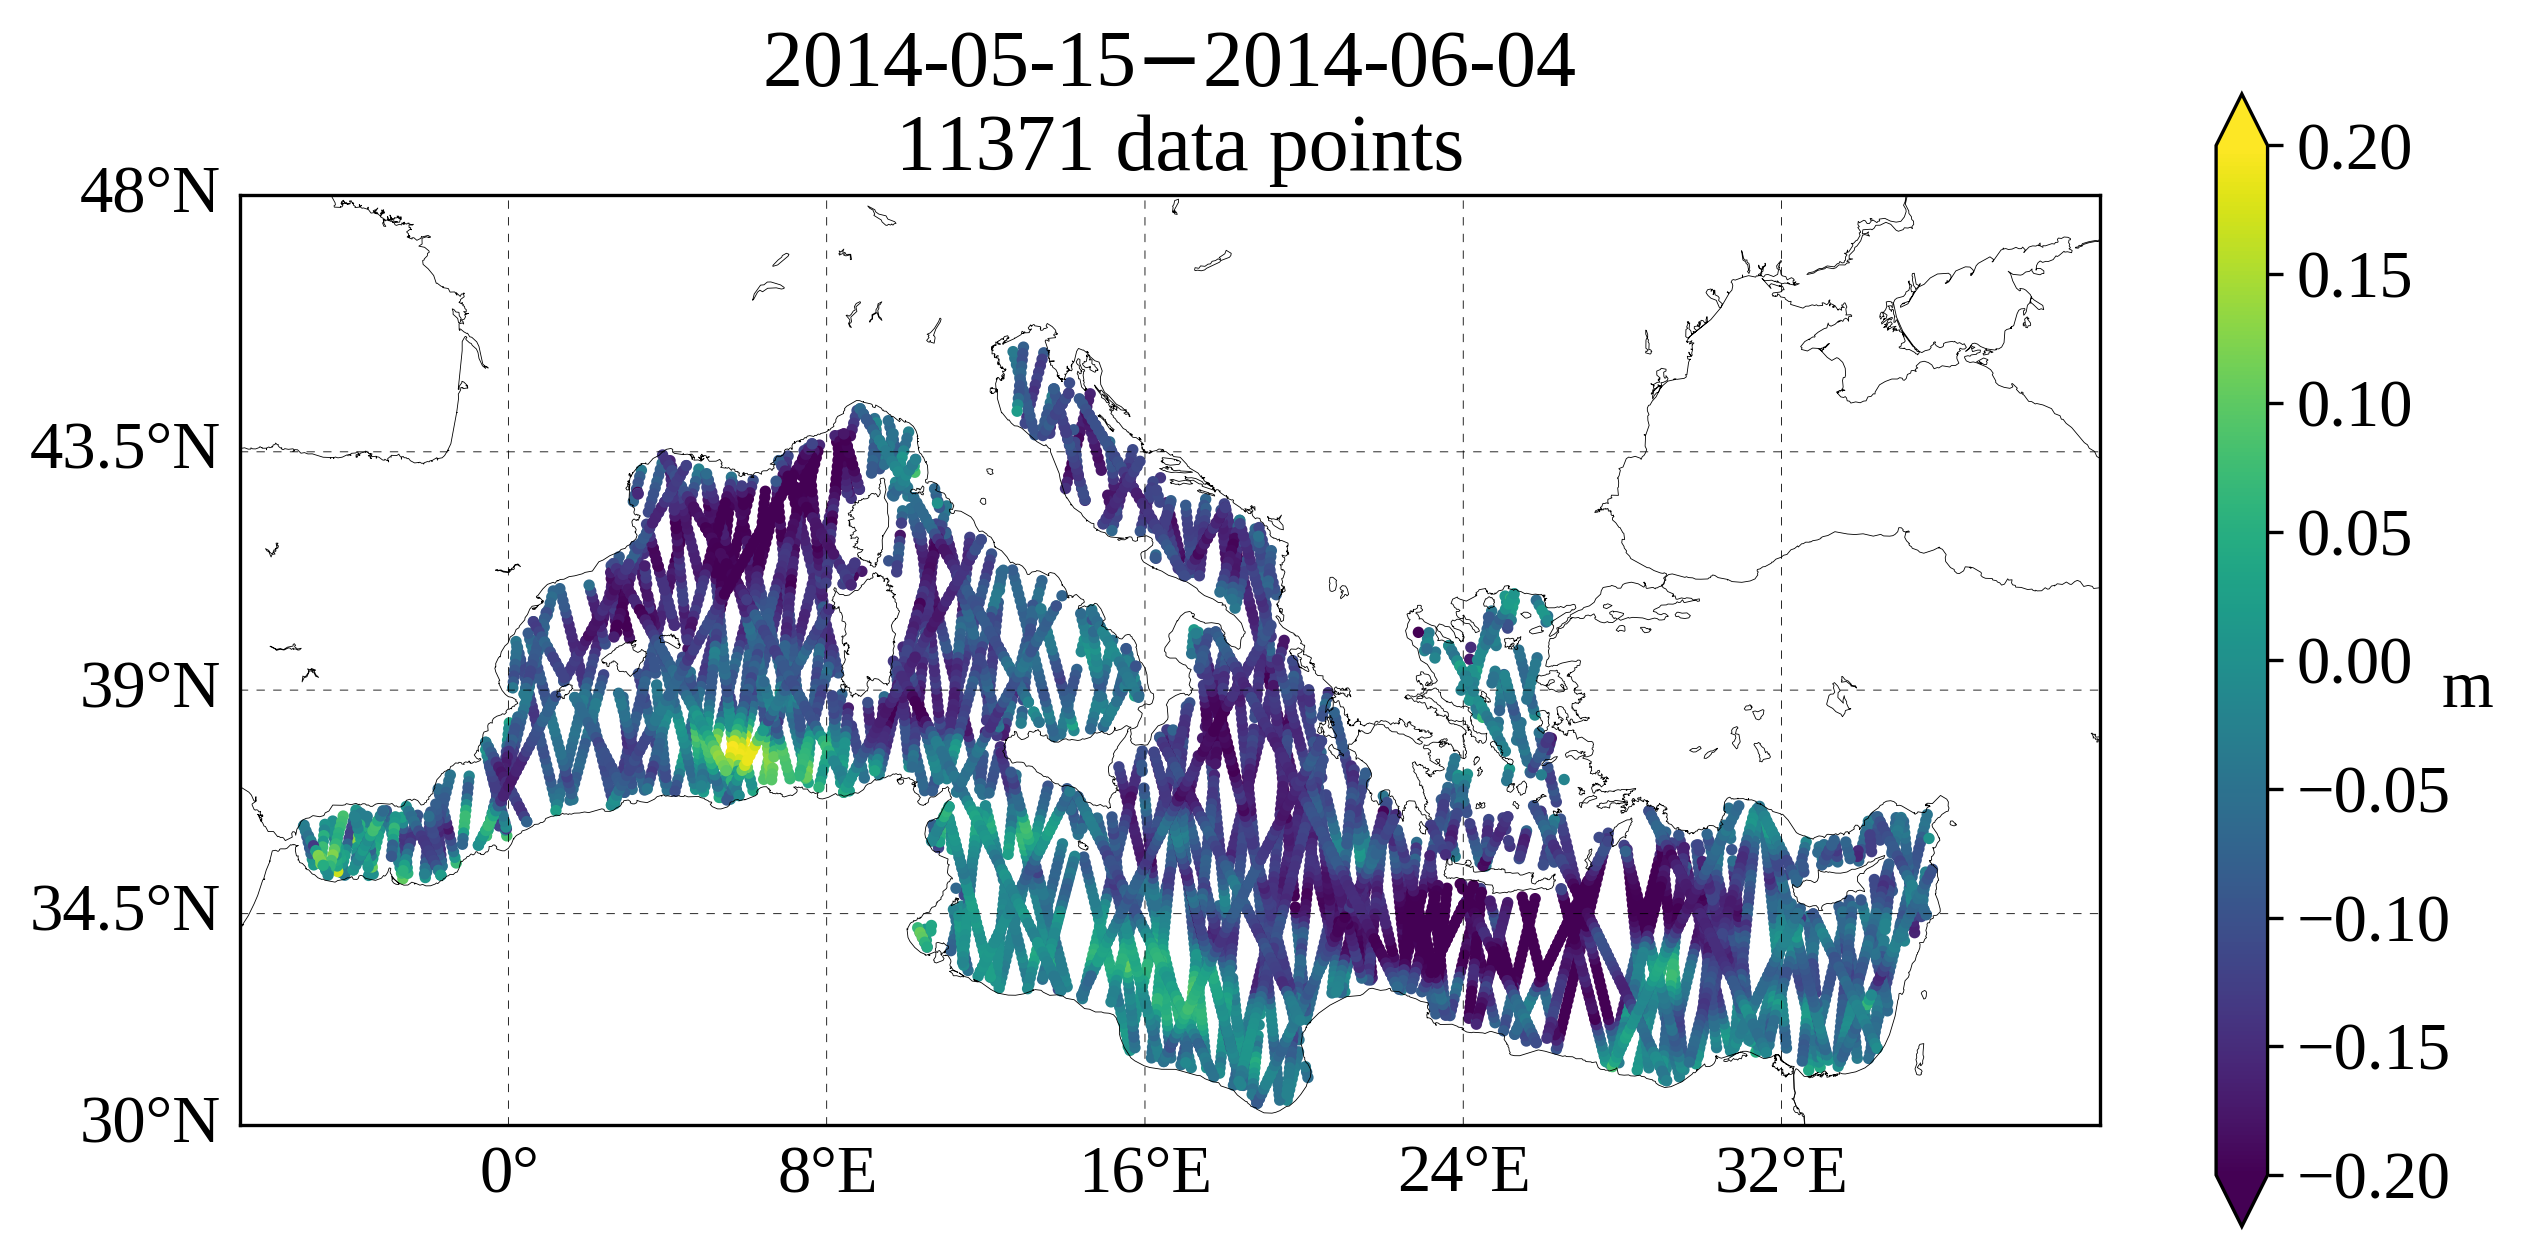

In [37]:
fig = plt.figure(figsize=(10, 10))
ax = plt.subplot(111)

npoints = 0

for file in filelist:
    track = Track(file)
    # Add track to the plot
    track.addToMap(m, marker='o', s=3, vmin=-.2, vmax=.2)
    # Count the number of points
    npoints += track.npoints
    # Write data to a text file
    track.writoToTextfile(os.path.join(outputdir, outputfilename))
    # Compute data weights and write a Diva2D data file
    track.writeToDivaFile(os.path.join(outputdir, divafilename), timescale, datemid)

# Add lines, coastline etc    
m.drawmeridians(np.arange(-8., round(coordinates[1]), 8), 
                labels=[0, 0, 0, 1], linewidth=.2)
m.drawparallels(np.linspace(round(coordinates[2]), round(coordinates[3]), 5), 
                labels=[1, 0, 0, 0], linewidth=.2)
m.drawcoastlines(linewidth=.2)
cbar = plt.colorbar(shrink=.5, extend='both')
cbar.set_label("m", rotation=0)
plt.title("{0} \n {1} data points".format(figtitledate, npoints))
# plt.savefig(os.path.join(figdir, figname), dpi=300)
plt.show()
plt.close()